In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def preprocess_image(image_path):
    """
    Load and preprocess an image for inference.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    tensor = transform(img)
    return tensor.unsqueeze(0), img

In [3]:
def get_last_conv_layer(model):
    """
    Get the last convolutional layer in the model.
    """
    # For ResNet architecture
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, nn.Conv2d):
            return name
    raise ValueError("No Conv2d layers found in the model.")

In [4]:
def apply_gradcam(model, image_tensor, target_class=None):
    """
    Apply Grad-CAM to an image.
    """
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)

    # Register hooks to get activations and gradients
    features = []
    gradients = []

    def forward_hook(module, input, output):
        features.append(output.detach())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    last_conv_layer_name = get_last_conv_layer(model)
    last_conv_layer = dict(model.named_modules())[last_conv_layer_name]
    handle_forward = last_conv_layer.register_forward_hook(forward_hook)
    handle_backward = last_conv_layer.register_backward_hook(backward_hook)

    # Forward pass
    model.eval()
    output = model(image_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Zero out all gradients
    model.zero_grad()

    # Backward pass
    one_hot = torch.zeros_like(output)
    one_hot[0][target_class] = 1
    output.backward(gradient=one_hot)

    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()

    # Get feature maps and gradients
    feature_map = features[-1].squeeze().cpu().numpy()
    gradient = gradients[-1].squeeze().cpu().numpy()

    # Global Average Pooling on gradients
    pooled_gradients = np.mean(gradient, axis=(1, 2), keepdims=True)
    cam = feature_map * pooled_gradients
    cam = np.sum(cam, axis=0)

    # Apply ReLU
    cam = np.maximum(cam, 0)

    # Normalize the CAM
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    # Resize CAM to match the original image size
    cam = cv2.resize(cam, (224, 224))

    return cam

In [5]:
def overlay_heatmap(original_image, heatmap, alpha=0.5):
    """
    Overlay the heatmap on the original image.
    
    Args:
        original_image (np.ndarray): Original image (H, W, 3), uint8
        heatmap (np.ndarray): Grad-CAM heatmap (H', W'), float between 0 and 1
        alpha (float): Weight for the heatmap
    
    Returns:
        np.ndarray: Overlayed image
    """
    # Ensure heatmap is 2D
    if heatmap.ndim == 3:
        heatmap = np.mean(heatmap, axis=2)

    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Normalize heatmap to [0, 255]
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Apply colormap
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Convert from BGR to RGB
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Superimpose: blend heatmap and original image
    superimposed_img = heatmap_colored * alpha + original_image * (1 - alpha)
    return np.uint8(superimposed_img)

def visualize_gradcam(model, image_path):
    """
    Visualize Grad-CAM for a given image.
    """
    # Preprocess image
    image_tensor, original_image = preprocess_image(image_path)  # (1, 3, 224, 224), (H, W, 3)
    original_image_np = np.array(original_image)  # PIL -> numpy array

    # Apply Grad-CAM
    cam = apply_gradcam(model, image_tensor)  # returns (224, 224)

    # Overlay heatmap on original image
    heatmap_overlay = overlay_heatmap(original_image_np, cam)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


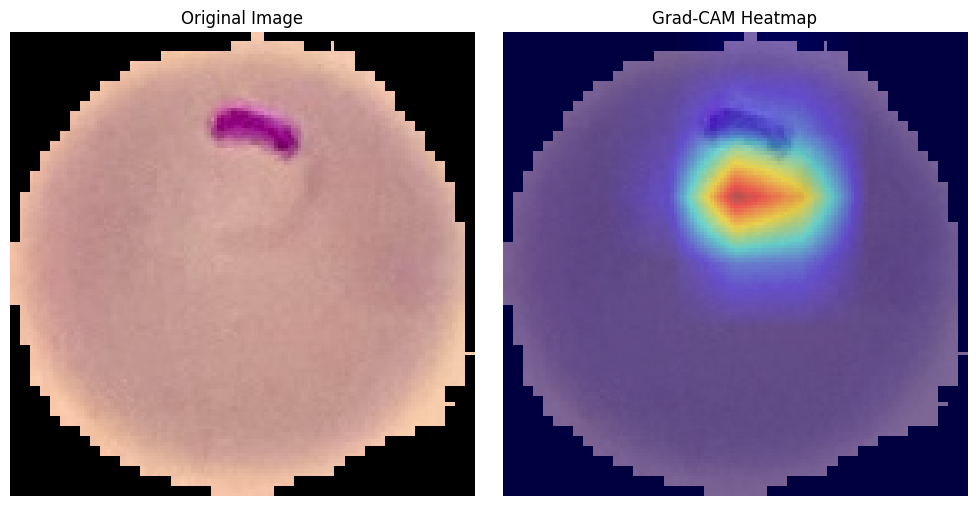

In [6]:
if __name__ == "__main__":

    from models.resnet_model import MalariaResNet50
    # Load your trained model
    model = MalariaResNet50(num_classes=2)
    model.load_state_dict(torch.load("models/malaria_model.pth"))
    model.eval()

    # Path to an image
    image_path = "malaria_ds/split_dataset/test/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_181.png"

    # Visualize Grad-CAM
    visualize_gradcam(model, image_path)